# importing libraries

In [117]:
import cv2 
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image
import torch
from torch import nn
import albumentations as A
from dataset import GreenChannelCLAHE
from dataset import FilteredDataset, VesselsSegmentationDataset
from albumentations.pytorch import ToTensorV2
from models.u_net import UNet,DiceLoss,BCEDiceLoss, DNLNetUNet, DeepVesselNet2D
from models.attention_unet import AttentionUNet , TverskyLoss
from sklearn.model_selection import train_test_split

# First model eye -> eye mask

## loading data for 1st model

In [120]:
transform = A.Compose([
    A.Resize(720, 720),
    GreenChannelCLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=1.0),
    ToTensorV2(),               # converts both image & mask to torch.FloatTensor
])

# Split the dataset into training and testing sets
train_indices, test_indices = train_test_split(range(len(os.listdir("./filtered_dataset/images"))), test_size=0.2, random_state=42)
# Create training and testing datasets
train_dataset = FilteredDataset(data_dir="./filtered_dataset", transform=transform, indices=train_indices)
test_dataset = FilteredDataset(data_dir="./filtered_dataset", transform=transform, indices=test_indices)

# Create dataloaders for training and testing
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

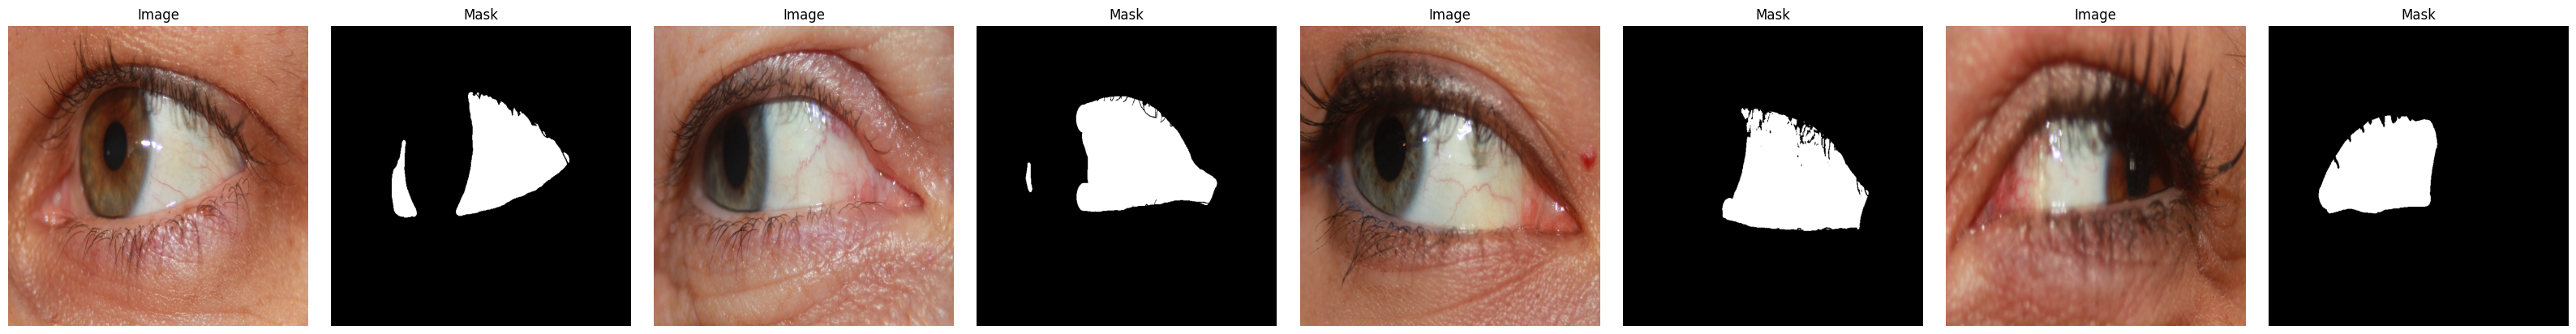

In [121]:
import matplotlib.pyplot as plt

# Get a batch
batch = next(iter(train_dataloader))
images, masks, filename = batch  # images: [B,3,H,W], masks: [B,1,H,W]

# Move to CPU & numpy
images = images.cpu().permute(0,2,3,1).numpy()  # [B,H,W,3]
masks  = masks.cpu().squeeze(1).numpy()         # [B,H,W]

# Normalize floats to [0,1]
# If max>1, assume range [0,255]
if images.max() > 1.0:
    images = images / 255.0
if masks.max() > 1.0:
    masks = masks / 255.0

# Plot
n = images.shape[0]
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols*2, figsize=(4*2*cols, 4*rows))

axes = axes.flatten()  # Flatten the axes array to make it one-dimensional

for i in range(n):
    ax_img = axes[i * 2]
    ax_msk = axes[i * 2 + 1]

    ax_img.imshow(images[i])
    ax_img.set_title("Image")
    ax_img.axis('off')

    ax_msk.imshow(masks[i], cmap='gray', vmin=0, vmax=1)
    ax_msk.set_title("Mask")
    ax_msk.axis('off')

# hide any unused subplots
for j in range(n, rows * cols):
    if j < len(axes):
        axes[j].axis('off')

plt.tight_layout()
plt.show()


In [122]:
def get_masking(original, mask):
    """
    Combines the original image with a single mask to generate a masked image.

    Args:
        original (torch.Tensor or np.ndarray): The original image tensor/array of shape (H, W, C) or (N, C, H, W).
        mask (torch.Tensor or np.ndarray): The mask tensor/array of shape (H, W) or (H, W, 1).

    Returns:
        torch.Tensor or np.ndarray: The masked image tensor/array of the same shape as the original.
    """
    # Ensure the mask has the same spatial dimensions as the original
    if isinstance(original, torch.Tensor) and isinstance(mask, torch.Tensor):
        if original.shape[-2:] != mask.shape[-2:]:
            mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0), size=original.shape[-2:], mode='nearest').squeeze(0).squeeze(0)
        if mask.dim() == 2:  # Add channel dimension if missing
            mask = mask.unsqueeze(0)
        if mask.shape[0] != original.shape[0]:  # Repeat mask across channels if needed
            mask = mask.expand(original.shape[0], -1, -1)
    elif isinstance(original, np.ndarray) and isinstance(mask, np.ndarray):
        if original.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (original.shape[1], original.shape[0]), interpolation=cv2.INTER_NEAREST)
        if mask.ndim == 2:  # Add channel dimension if missing
            mask = np.expand_dims(mask, axis=-1)
        if mask.shape[-1] != original.shape[-1]:  # Repeat mask across channels if needed
            mask = np.repeat(mask, original.shape[-1], axis=-1)
    else:
        raise TypeError("Both original and mask must be either torch.Tensor or np.ndarray")

    # Apply the mask to the original image
    masked_image = original * mask

    return masked_image


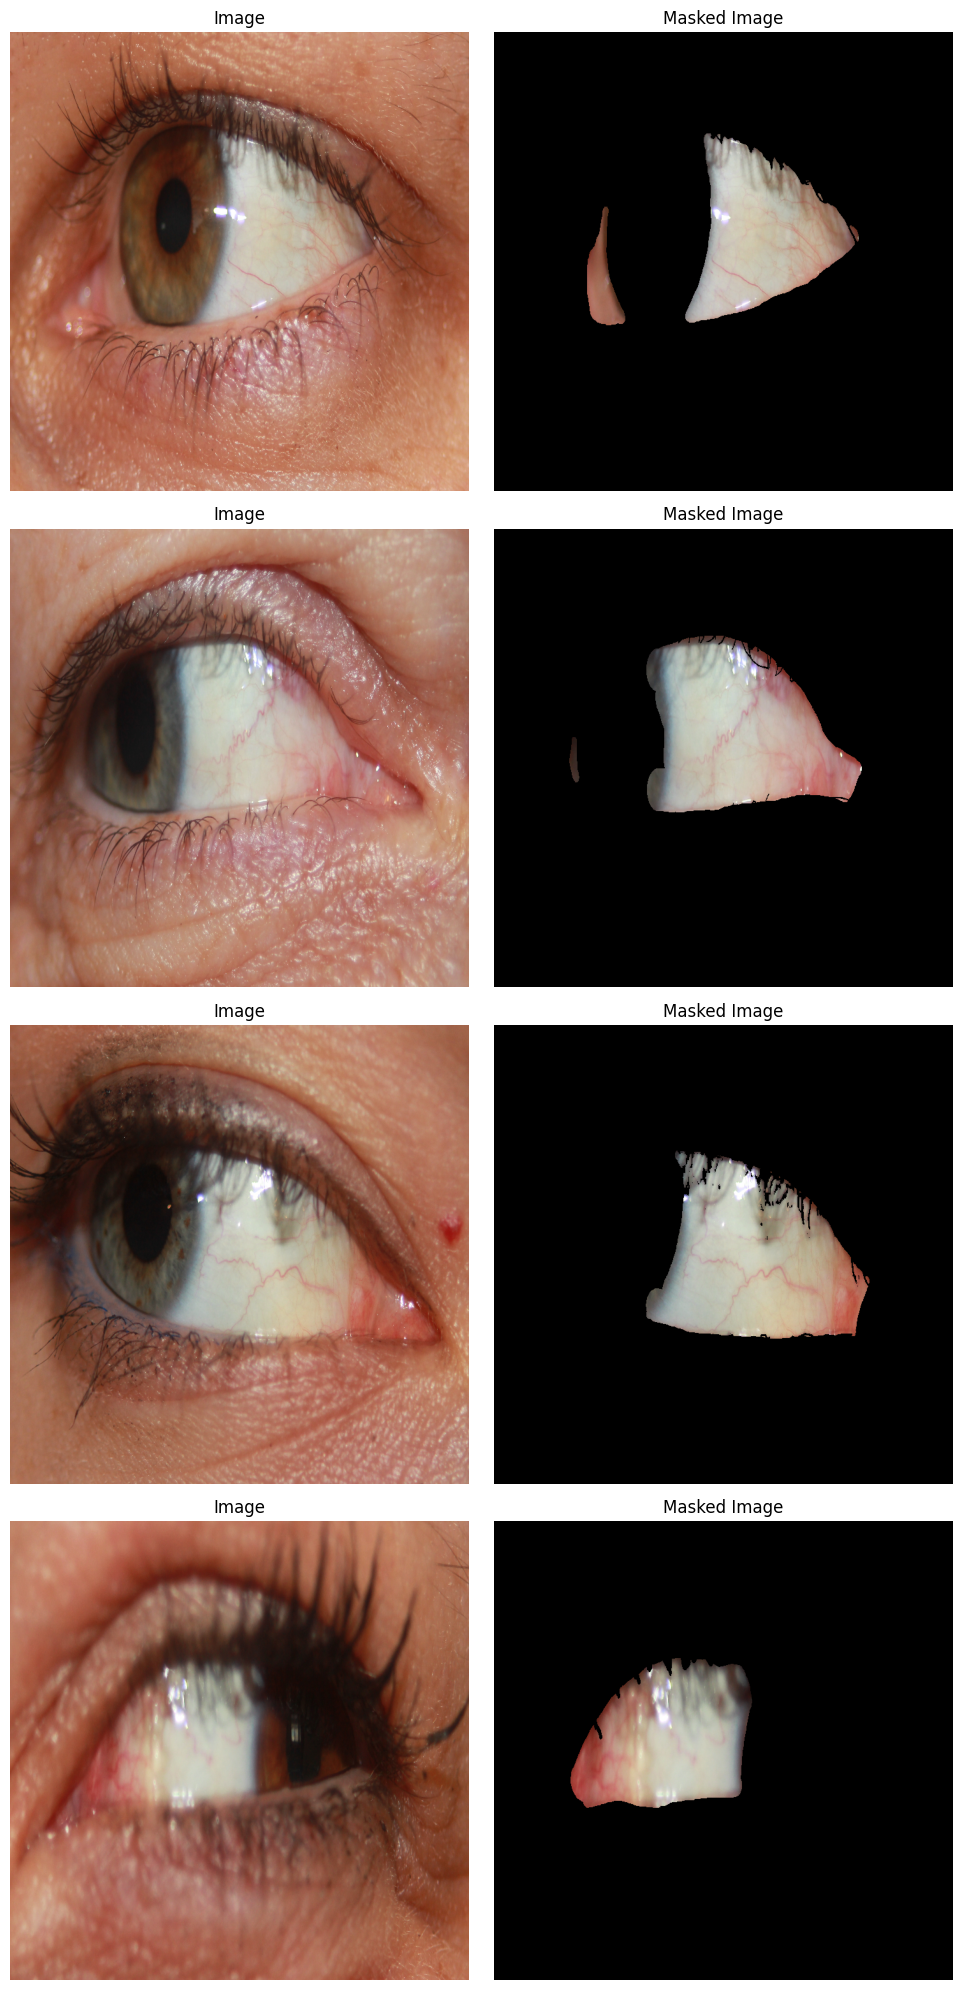

In [123]:
# Plot the images and corresponding masks
fig, axes = plt.subplots(len(images), 2, figsize=(10, 5 * len(images)))
for i in range(len(images)):
    axes[i, 0].imshow(images[i])
    axes[i, 0].set_title("Image")
    axes[i, 0].axis('off')
    
    # Convert NumPy arrays to PyTorch tensors
    image_tensor = torch.tensor(images[i]).permute(2, 0, 1)  # Convert HWC to CHW
    mask_tensor = torch.tensor(masks[i]).unsqueeze(0)  # Add channel dimension

    # Apply masking
    masked_image = get_masking(image_tensor, mask_tensor)

    # Convert the masked image back to NumPy for visualization
    masked_image = masked_image.permute(1, 2, 0).numpy()  # Convert CHW to HWC
    axes[i, 1].imshow(masked_image)
    axes[i, 1].set_title("Masked Image")
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()

## need not to run this, code below create dataset for part 2

In [6]:
# # Ensure the output directory exists
# output_dir = "./filtered_dataset/masked_images"
# os.makedirs(output_dir, exist_ok=True)
# original_images_dir = "./filtered_dataset/images"  # Directory containing original images

# for idx, batch in enumerate(train_dataloader):
#     images, masks, filenames = batch  # Make sure your DataLoader returns filenames too
#     for i in range(len(images)):
#         image_tensor = images[i]
#         mask_tensor = masks[i]
#         filename = filenames[i] 

#         # Apply masking
#         masked_image = get_masking(image_tensor, mask_tensor)

#         # Convert the masked image back to NumPy for saving
#         masked_image = masked_image.permute(1, 2, 0).numpy().astype('uint8')

#         # Convert to PIL Image and save
#         # Enhance veins by applying CLAHE to the green channel
#         green_channel = masked_image[:, :, 1]  # Extract the green channel
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#         enhanced_green = clahe.apply(green_channel)

#         # Replace the green channel with the enhanced version
#         masked_image[:, :, 1] = enhanced_green

#         # Convert to PIL Image and save
#         pil_image = Image.fromarray(masked_image)
#         new_name = f"{filename}_masked_image.png"
#         pil_image.save(os.path.join(output_dir, new_name))

# Unet training

### helper functions

In [124]:
def compute_iou_and_f1(pred_mask, true_mask, threshold=0.5):
    """
    Computes IoU and F1 (Dice) score for binary segmentation masks from logits.

    Args:
        logits (torch.Tensor): Raw output from model (logits), shape (H, W)
        true_mask (torch.Tensor): Ground truth binary mask, shape (H, W)
        threshold (float): Threshold to binarize the sigmoid output

    Returns:
        iou (float), f1 (float)
    """
    pred_mask = torch.tensor(pred_mask) if not isinstance(pred_mask, torch.Tensor) else pred_mask
    true_mask = torch.tensor(true_mask) if not isinstance(true_mask, torch.Tensor) else true_mask

    pred_mask = pred_mask > threshold

    # Flatten both masks
    pred_mask = pred_mask.view(-1).int()
    true_mask = true_mask.view(-1).int()

    intersection = (pred_mask & true_mask).sum()
    union = (pred_mask | true_mask).sum()

    iou = (intersection / union).item() if union != 0 else 1.0

    denom = pred_mask.sum() + true_mask.sum()
    f1 = (2 * intersection / denom).item() if denom != 0 else 1.0

    return iou, f1

def evaluate_segmentation(model, loader, device):
    model.eval()
    total_iou, total_f1, count = 0.0, 0.0, 0

    with torch.no_grad():
        for images, masks, _ in loader:
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)  # raw logits, shape (B, 1, H, W) or (B, H, W)

            if preds.dim() == 4:  # Ensure single channel output
                preds = preds[:, 0, :, :]
            elif preds.dim() == 3:
                pass
            else:
                raise ValueError(f"Unexpected prediction shape: {preds.shape}")
            preds = torch.sigmoid(preds)  # Apply sigmoid to get probabilities
            preds = (preds > 0.6).float()  # Binarize predictions
            for i in range(images.size(0)):
                iou, f1 = compute_iou_and_f1(preds[i], masks[i])
                total_iou += iou
                total_f1 += f1
                count += 1

    return total_iou / count, total_f1 / count

def combined_loss(pred, target, epsilon=1e-8, gamma=2, alpha=0.25):
    # Dice loss
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection + epsilon) / (union + epsilon)

    # Focal loss
    BCE_loss = nn.BCELoss(reduction='none')(pred, target)
    pt = torch.exp(-BCE_loss)
    focal_loss = alpha * (1 - pt) ** gamma * BCE_loss
    focal_loss = focal_loss.mean()

    return dice + focal_loss

import matplotlib.pyplot as plt
import os
import numpy as np
import torch

def visualize_batch(model, loader, device, epoch, save_dir, threshold=0.5):
    model.eval()
    imgs, _, __ = next(iter(loader))  # Assumes loader yields (img, mask, optional_name)
    imgs = imgs.to(device)

    with torch.no_grad():
        preds = model(imgs)
        preds = (preds > threshold).float()

    preds = preds.cpu()
    imgs = imgs.cpu()

    os.makedirs(save_dir, exist_ok=True)
    fig, axes = plt.subplots(2, len(imgs), figsize=(4 * len(imgs), 6))

    axes = np.atleast_2d(axes)  # ensure axes is always 2D

    for i in range(len(imgs)):
        img_np = imgs[i].permute(1, 2, 0).numpy()
        if img_np.max() > 1:
            img_np = img_np / 255.0
        img_np = np.clip(img_np, 0, 1)

        axes[0, i].imshow(img_np.squeeze(), cmap='gray' if img_np.shape[2] == 1 else None)
        axes[0, i].axis('off')
        axes[0, i].set_title("Input")

        axes[1, i].imshow(preds[i, 0].numpy(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Prediction")

    fig.suptitle(f'Epoch {epoch} Segmentation')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'epoch_{epoch}.png'))
    plt.close(fig)
def visualize_batch(model, loader, device, epoch, save_dir, threshold=0.5):
    model.eval()
    imgs, _, _ = next(iter(loader))
    imgs = imgs.to(device)

    with torch.no_grad():
        preds = model(imgs)
        preds = (preds > threshold).float()

    preds = preds.cpu()
    imgs = imgs.cpu()

    os.makedirs(save_dir, exist_ok=True)
    fig, axes = plt.subplots(2, len(imgs), figsize=(4 * len(imgs), 6))

    # If only one column, axes is 1D:
    if axes.ndim == 1:
        axes = np.expand_dims(axes, axis=1)  # shape becomes (2,1)

    for i in range(len(imgs)):
        img = imgs[i]
        # normalize if needed
        img_np = img.permute(1, 2, 0).numpy()
        if img_np.max() > 1:
            img_np = img_np / 255.0
        img_np = np.clip(img_np, 0, 1)

        axes[0, i].imshow(img_np.squeeze(), 
                          cmap='gray' if img_np.shape[-1] == 1 else None)
        axes[0, i].axis('off')
        axes[0, i].set_title("Input")

        mask_np = preds[i, 0].numpy()
        axes[1, i].imshow(mask_np, cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Pred")

    fig.suptitle(f'Epoch {epoch} Segmentation')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'epoch_{epoch}.png'))
    plt.close(fig)


In [125]:
# model training and visualization
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for images, masks, filename in dataloader:
        images = images.to(device)
        masks = masks.to(device)
        if masks.dim() == 3:
            masks = masks.unsqueeze(1)
        masks = masks.float()  # ADD THIS LINE
        masks = torch.clamp(masks, 0.0, 1.0)  # Ensure masks are in [0, 1]
        optimizer.zero_grad()
        outputs = model(images)
        # outputs = torch.sigmoid(outputs)  # Apply sigmoid to ensure outputs are in [0, 1]
        
        # Ensure masks have the same shape as outputs
        if outputs.shape != masks.shape:
            raise ValueError(f"Shape mismatch: outputs {outputs.shape}, masks {masks.shape}")
        
        
        loss = criterion(outputs, masks) + combined_loss(outputs, masks)
        # loss.requires_grad = True
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)



### training loop

In [9]:
# # Training the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = AttentionUNet(3,1).to(device)
# criterion = lambda pred, target: nn.BCEWithLogitsLoss()(pred, target) + TverskyLoss()(pred, target)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# save_dir = "segment_results/sclera_segmentation"
# os.makedirs(save_dir, exist_ok=True)

# log_file = os.path.join(save_dir, "metrics_log.txt")
# with open(log_file, "w") as f:
#     f.write("Epoch,Loss,IoU,F1\n")  # header

# num_epochs = 50
# for ep in range(1, num_epochs + 1):
#     loss = train_model(model, train_dataloader, optimizer, criterion, device)
#     iou, f1 = evaluate_segmentation(model, test_dataloader, device)

#     print(f"Epoch [{ep}/{num_epochs}] Loss: {loss:.4f} | IoU: {iou:.4f} | F1: {f1:.4f}")
#     with open(log_file, "a") as f:
#         f.write(f"{ep},{loss:.4f},{iou:.4f},{f1:.4f}\n")

#     visualize_batch(model, test_dataloader, device, ep, save_dir)
#     scheduler.step()

# print("Training complete. Segmentation snapshots and metrics in 'segment_results/'.")
# torch.save(model.state_dict(), os.path.join("./trained-models", "model_50_attention.pth"))

IoU: 0.7911, F1 Score: 0.8834


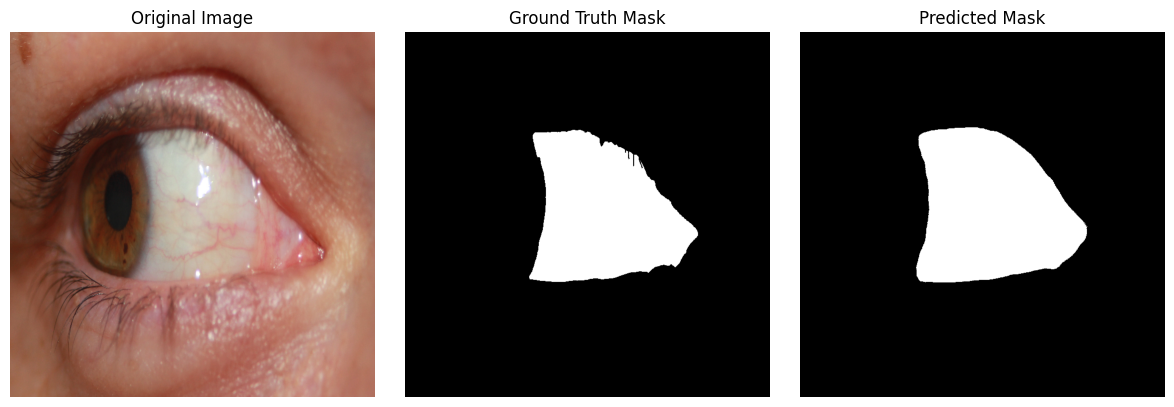

In [136]:
# Get one sample batch from test dataloader
sample_image, sample_mask, _ = next(iter(test_dataloader))  # Shape: [B, C, H, W], [B, 1, H, W]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = AttentionUNet(3, 1).to(device)  # Ensure model is on the same device
model1.load_state_dict(torch.load("trained-models/model_50_attention.pth"))  # Load the trained model
model1.eval()

sample_image = sample_image.to(device)
sample_mask = sample_mask.to(device)

# Set model to evaluation mode
model1.eval()

with torch.no_grad():
    preds = model1(sample_image)
    preds = torch.sigmoid(preds)
    threshold = 0.6
    binarized_preds = (preds > threshold).float()
    # binarized_preds = preds

# Compute IoU and F1 Score
iou, f1 = compute_iou_and_f1(binarized_preds, sample_mask, threshold=threshold)
print(f"IoU: {iou:.4f}, F1 Score: {f1:.4f}")

# Take the first item in the batch for visualization
image_np = sample_image[1].permute(1, 2, 0).cpu().numpy()  # CHW to HWC
mask_np = sample_mask[1].squeeze().cpu().numpy()
prediction_np = binarized_preds[1].squeeze().cpu().numpy()

# Normalize image if needed
if image_np.max() > 1.0:
    image_np = image_np / 255.0

# Plot the image, ground truth, and prediction
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(mask_np, cmap='gray', vmin=0, vmax=1)
axes[1].set_title("Ground Truth Mask")
axes[1].axis('off')

axes[2].imshow(prediction_np, cmap='gray', vmin=0, vmax=1)
axes[2].set_title("Predicted Mask")
axes[2].axis('off')

plt.tight_layout()
plt.show()


# Second Model masked image -> eye vessels

## loading data for 2nd Model

In [129]:
from torch.utils.data import random_split

transform = A.Compose([
    A.Resize(512, 512),
    GreenChannelCLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=1.0),
    ToTensorV2(),               # converts both image & mask to torch.FloatTensor
])
vesseldataset = VesselsSegmentationDataset(data_dir="./filtered_dataset", transform=transform)
# Split the dataset into training and testing sets
train_size = int(0.8 * len(vesseldataset))  # 80% for training
test_size = len(vesseldataset) - train_size
vessel_train_dataset, vessel_test_dataset = random_split(vesseldataset, [train_size, test_size])

# Create dataloaders for training and testing
vessel_train_dataloader = torch.utils.data.DataLoader(vessel_train_dataset, batch_size=4, shuffle=True)
vessel_test_dataloader = torch.utils.data.DataLoader(vessel_test_dataset, batch_size=4, shuffle=False)


## displaying some images and maskes 

/tmp/ipykernel_1101509/672899509.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.stack([torch.tensor(img).permute(2, 0, 1) for img in transformed_images])  # [B, C, H, W]
/tmp/ipykernel_1101509/672899509.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.stack([torch.tensor(mask).unsqueeze(0) for mask in transformed_masks])  # [B, 1, H, W]


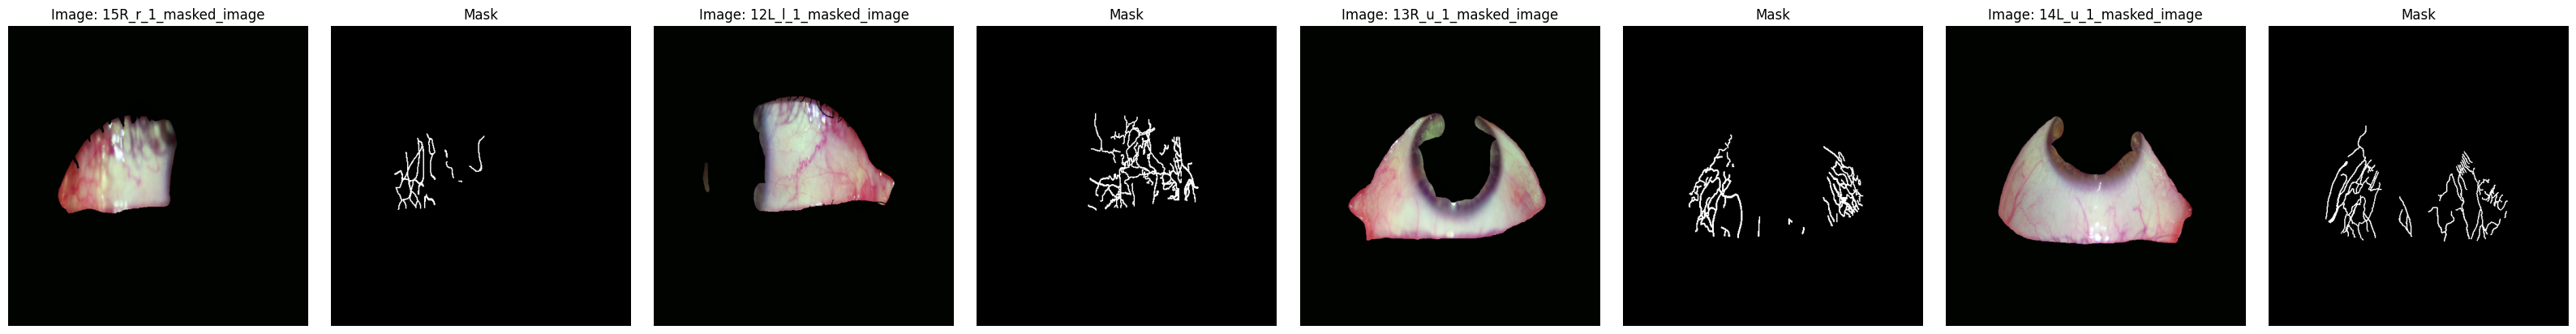

In [130]:
images, masks, filenames = next(iter(vessel_train_dataloader))  # images: [B, C, H, W], masks: [B, 1, H, W]

# Apply the transform to each image and mask
transformed_images = []
transformed_masks = []
for i in range(len(images)):
    transformed = transform(image=images[i].permute(1, 2, 0).cpu().numpy(), mask=masks[i].squeeze().cpu().numpy())
    transformed_images.append(transformed['image'])
    transformed_masks.append(transformed['mask'])

# Convert lists back to tensors
images = torch.stack([torch.tensor(img).permute(2, 0, 1) for img in transformed_images])  # [B, C, H, W]
masks = torch.stack([torch.tensor(mask).unsqueeze(0) for mask in transformed_masks])  # [B, 1, H, W]

# Move to CPU & numpy for visualization
images = images.cpu().permute(0, 2, 3, 1).numpy()  # [B, H, W, C]
masks = masks.cpu().squeeze(1).numpy()  # [B, H, W]

# Normalize images to [0, 1] if needed
if images.max() > 1.0:
    images = images / 255.0

# Plot the images and masks
n = len(images)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols * 2, figsize=(4 * 2 * cols, 4 * rows))
axes = axes.flatten()

for i in range(n):
    ax_img = axes[i * 2]
    ax_msk = axes[i * 2 + 1]

    ax_img.imshow(images[i].transpose(1, 2, 0))  # Convert (H, W, C) for matplotlib
    ax_img.set_title(f"Image: {filenames[i]}")
    ax_img.axis('off')

    ax_msk.imshow(masks[i], cmap='gray', vmin=0, vmax=1)
    ax_msk.set_title("Mask")
    ax_msk.axis('off')

# Hide unused subplots
for j in range(n * 2, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Training Loop for 2nd model

In [ ]:
# # Training the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# vessel_unet = UNet(3, 1).to(device)
# criterion = lambda pred, target: nn.BCEWithLogitsLoss()(pred, target) + TverskyLoss()(pred, target)
# optimizer = torch.optim.Adam(vessel_unet.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR every 10 epochs

# save_dir = "segment_results/vessel_segmentation"
# os.makedirs(save_dir, exist_ok=True)

# log_file = os.path.join(save_dir, "metrics_log.txt")
# with open(log_file, "w") as f:
#     f.write("Epoch,Loss,IoU,F1\n")  # header

# num_epochs = 80
# for ep in range(1, num_epochs + 1):
#     loss = train_model(vessel_unet, vessel_train_dataloader, optimizer, criterion, device)
#     iou, f1 = evaluate_segmentation(vessel_unet, vessel_test_dataloader, device)

#     print(f"Epoch [{ep}/{num_epochs}] Loss: {loss:.4f} | IoU: {iou:.4f} | F1: {f1:.4f}")
#     with open(log_file, "a") as f:
#         f.write(f"{ep},{loss:.4f},{iou:.4f},{f1:.4f}\n")

#     visualize_batch(vessel_unet, vessel_test_dataloader, device, ep, save_dir)

#     # Step the scheduler at the end of the epoch
#     scheduler.step()

# print("Training complete. Segmentation snapshots and metrics in 'segment_results/'.")
# torch.save(vessel_unet.state_dict(), os.path.join("./trained-models", "vessel_segmentation_model_80.pth"))

## testing the model

Batch IoU: 0.0030, F1: 0.0061


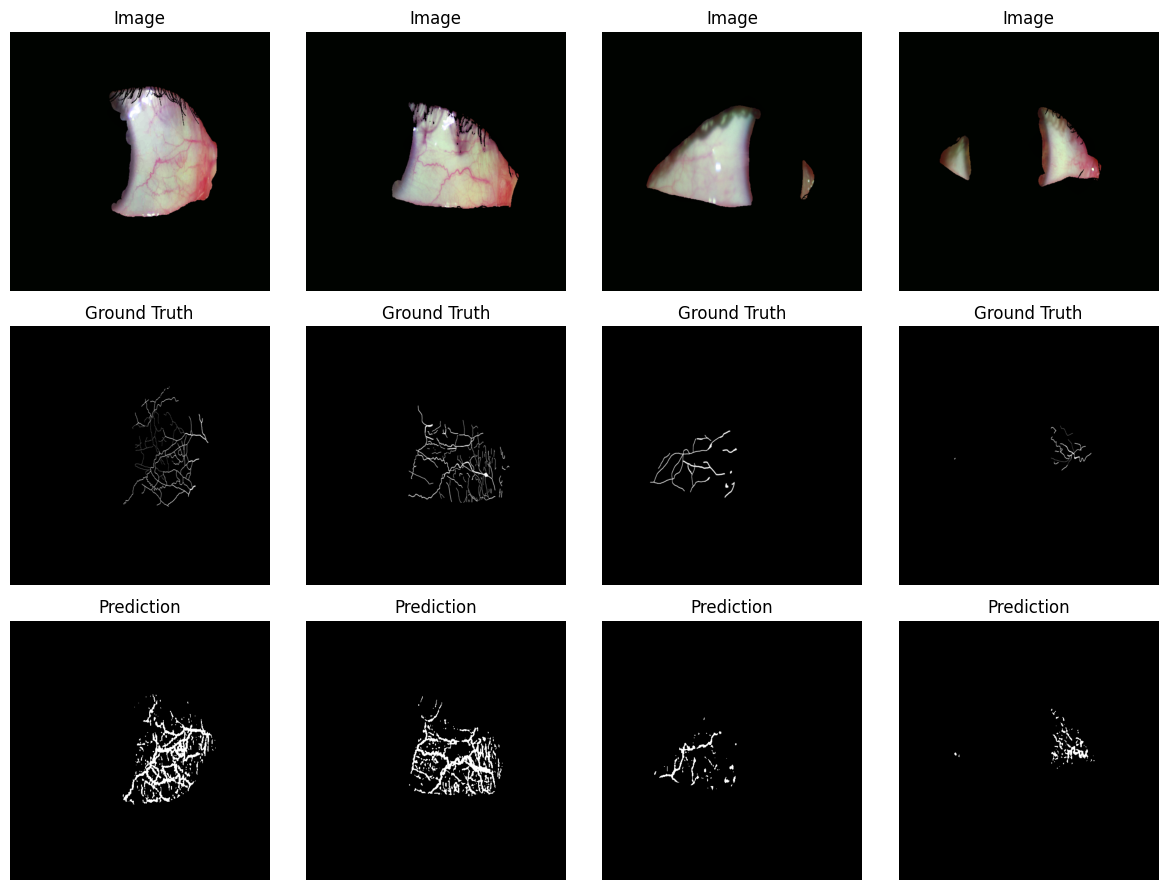

In [131]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(3, 1).to(device)
model.load_state_dict(torch.load("trained-models/vessel_segmentation_model_80.pth"))
model.eval()

# Load a single batch
images, masks, _ = next(iter(vessel_test_dataloader))
images, masks = images.to(device), masks.to(device)

# Predict
with torch.no_grad():
    preds = model(images)
    preds = torch.sigmoid(preds)
    preds = (preds > 0.6).float()

# Evaluate the batch
total_iou, total_f1 = 0.0, 0.0
for i in range(images.size(0)):
    iou, f1 = compute_iou_and_f1(preds[i], masks[i])
    total_iou += iou
    total_f1 += f1
print(f"Batch IoU: {total_iou / len(images):.4f}, F1: {total_f1 / len(images):.4f}")

# Visualize predictions
num_images = min(4, len(images))  # Display up to 4 images
images = images.cpu()
preds = preds.cpu()
masks = masks.cpu()

fig, axes = plt.subplots(3, num_images, figsize=(num_images * 3, 9))
for i in range(num_images):
    img_np = images[i].permute(1, 2, 0).numpy()
    if img_np.max() > 1.0:
        img_np = img_np / 255.0  # Normalize to [0, 1] if max value > 1
    axes[0, i].imshow(img_np)
    axes[0, i].set_title("Image")
    axes[0, i].axis('off')

    axes[1, i].imshow(masks[i], cmap='gray')
    axes[1, i].set_title("Ground Truth")
    axes[1, i].axis('off')

    axes[2, i].imshow(preds[i, 0], cmap='gray')
    axes[2, i].set_title("Prediction")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

# VesselNet => combined Model

In [132]:
class VesselNet(nn.Module):
    def __init__(self,
                 eye_mask_weights="trained-models/model_50_attention.pth",
                 vessel_weights="trained-models/vessel_segmentation_model_80.pth",
                 device=None):
        super(VesselNet, self).__init__()
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load the two pretrained U‑Nets
        self.unet_eye_mask = AttentionUNet(3, 1).to(self.device)
        self.unet_vessel   = UNet(3, 1).to(self.device)

        self.unet_eye_mask.load_state_dict(torch.load(eye_mask_weights, map_location=self.device))
        self.unet_vessel.load_state_dict(torch.load(vessel_weights, map_location=self.device))

        self.unet_eye_mask.eval()
        self.unet_vessel.eval()

        # Stage‑1 transform (for eye mask)
        self.transform_eye_mask = A.Compose([
            A.Resize(720, 720),
            GreenChannelCLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
            ToTensorV2()
        ])

        # Stage‑2 transform (for vessel mask)
        self.transform_vessel_mask = A.Compose([
            A.Resize(512, 512),
            GreenChannelCLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
            ToTensorV2()
        ])

        self.threshold = 0.
        self.masking_function = get_masking

    def _load_image(self, path):
        """Load image as HWC numpy in [0,255]."""
        if not os.path.isfile(path):
            raise FileNotFoundError(f"Image at path {path} does not exist.")
        img = cv2.imread(path)
        if img is None:
            raise FileNotFoundError(f"Image at path {path} could not be loaded.")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        return img

    def forward(self, image_paths):
        """Process a batch of image paths through the VesselNet pipeline."""
        results = []

        for path in image_paths:
            # Load and transform image for eye mask
            original_img = self._load_image(path)
            transformed_eye = self.transform_eye_mask(image=original_img)
            input_eye = transformed_eye["image"].unsqueeze(0).to(self.device)  # [1, 3, 720, 720]

            # Stage 1: Eye mask prediction
            with torch.no_grad():
                eye_mask_pred = torch.sigmoid(self.unet_eye_mask(input_eye))  # [1, 1, 720, 720]
                binary_mask = (eye_mask_pred > self.threshold).float()

            # Apply eye mask to original image (720x720)
            resized_img = cv2.resize(original_img, (720, 720))
            masked_img = self.masking_function(resized_img, binary_mask.squeeze().cpu().numpy())  # numpy masked

            # Transform masked image for vessel segmentation
            transformed_vessel = self.transform_vessel_mask(image=masked_img)
            input_vessel = transformed_vessel["image"].unsqueeze(0).to(self.device)  # [1, 3, 512, 512]

            # Stage 2: Vessel segmentation
            with torch.no_grad():
                vessel_pred = torch.sigmoid(self.unet_vessel(input_vessel))  # [1, 1, 512, 512]

            results.append(vessel_pred.squeeze(0).cpu())  # [1, H, W] → [H, W]

        return results  # List of tensors


In [133]:
# Define VesselNet exactly as you've given

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vessel_net = VesselNet(
    eye_mask_weights="trained-models/model_50_attention.pth",
    vessel_weights="trained-models/vessel_segmentation_model_80.pth",
    device=device
)

# Run inference on a sample image
image_path = "./filtered_dataset/images/3R_l_1.jpg"

vessel_net.eval()
with torch.no_grad():
    vessel_mask = vessel_net(image_path)  # returns (B,1,512,512)

original_image = Image.open(image_path).convert('RGB')  # 'L' for grayscale
# Plot original image and predicted mask side by side
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='gray')
plt.title("Predicted Vessel Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


FileNotFoundError: Image at path . does not exist.

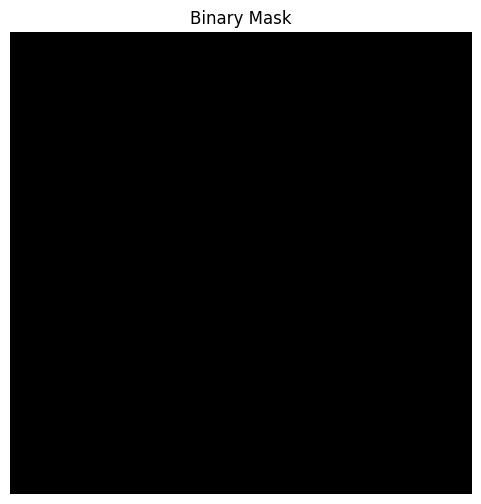

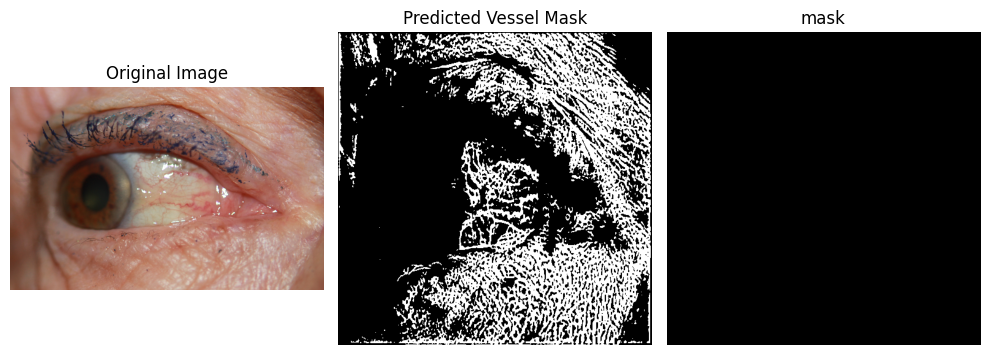

In [137]:
def process_image(image_path, eye_mask_weights, vessel_weights, device=None):
    """
    Function to process the image through the pipeline of eye mask and vessel segmentation.

    Parameters:
        image_path (str): Path to the input image.
        eye_mask_weights (str): Path to the pretrained eye mask model weights.
        vessel_weights (str): Path to the pretrained vessel segmentation model weights.
        device (torch.device): Device to run the models on (either 'cuda' or 'cpu').

    Returns:
        np.array: Final vessel segmentation mask.
    """
    # Check if the image exists
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Image at path {image_path} does not exist.")
    
    # Load the image (RGB)
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image at path {image_path} could not be loaded.")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Load models
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    unet_eye_mask = AttentionUNet(3, 1).to(device)
    unet_vessel = UNet(3, 1).to(device)

    unet_eye_mask.load_state_dict(torch.load(eye_mask_weights, map_location=device))
    unet_vessel.load_state_dict(torch.load(vessel_weights, map_location=device))

    unet_eye_mask.eval()
    unet_vessel.eval()

    # Stage-1 transform (for eye mask)
    transform_eye_mask = A.Compose([
        A.Resize(720, 720),
        GreenChannelCLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
        ToTensorV2()
    ])

    # Stage-2 transform (for vessel mask)
    transform_vessel_mask = A.Compose([
        A.Resize(512, 512),
        # GreenChannelCLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
        ToTensorV2()
    ])

    # Apply the transform and model pipeline
    transformed_eye = transform_eye_mask(image=img)
    input_eye = transformed_eye["image"].unsqueeze(0).to(device)  # [1, 3, 720, 720]

    # Stage 1: Eye mask prediction
    with torch.no_grad():
        eye_mask_pred = torch.sigmoid(unet_eye_mask(input_eye.float()))  # Ensure input is float
        binary_mask = (eye_mask_pred > 0).float()  # Apply threshold

    # Visualize the binary mask
    plt.figure(figsize=(6, 6))
    plt.imshow(binary_mask.squeeze().cpu().numpy(), cmap='gray')
    plt.title("Binary Mask")
    plt.axis('off')
    plt.show()

    # Apply eye mask to the original image (720x720)
    resized_img = cv2.resize(img, (720, 720))
    masked_img = get_masking(resized_img, binary_mask.squeeze().cpu().numpy())  # Apply the mask

    # Transform the masked image for vessel segmentation
    transformed_vessel = transform_vessel_mask(image=masked_img)
    input_vessel = transformed_vessel["image"].unsqueeze(0).to(device)  # [1, 3, 512, 512]

    # Stage 2: Vessel segmentation
    with torch.no_grad():
        vessel_pred = torch.sigmoid(unet_vessel(input_vessel))  # [1, 1, 512, 512]

    # Convert the result to a numpy array and return
    vessel_mask = vessel_pred.squeeze(0).cpu().numpy()
    return vessel_mask, binary_mask.squeeze().cpu().numpy()  # Return both vessel mask and eye mask

# Example usage
image_path = "./filtered_dataset/images/4L_l_1.jpg"
eye_mask_weights = "trained-models/model_50_attention.pth"
vessel_weights = "trained-models/vessel_segmentation_model_80.pth"

# Run the pipeline
vessel_mask,binary_mask = process_image(image_path, eye_mask_weights, vessel_weights)
vessel_mask = (vessel_mask > 0.5).astype(np.uint8)  # Binarize the mask
# Visualize the result
original_image = Image.open(image_path).convert('RGB')

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(vessel_mask.squeeze(), cmap='gray')
plt.title("Predicted Vessel Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(binary_mask, cmap='gray')
plt.title("mask")
plt.axis('off')
plt.tight_layout()

plt.show()

In [ ]:
from flask import Flask, request, jsonify ,render_template

app = Flask(__name__)
app.config["UPLOAD_FOLDER"] = "static/uploads"
os.makedirs(app.config["UPLOAD_FOLDER"], exist_ok=True)

@app.route("/home", methods=['GET'])
def home():
    return render_template("index.html")

@app.route('/predict',methods = ['POST'])
def predict():
    

SyntaxError: incomplete input (2610407219.py, line 12)